# Import the flight data as a .csv file

In [1]:
!curl https://topcs.blob.core.windows.net/public/FlightData.csv -o flightdata.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1552k  100 1552k    0     0  1366k      0  0:00:01  0:00:01 --:--:-- 1374k


# Create and print the Pandas dataframe 

In [2]:
import pandas as pd

df = pd.read_csv('flightdata.csv')
df.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK UNIQUE_CARRIER TAIL_NUM  \
0  2016        1      1             1            5             DL   N836DN   
1  2016        1      1             1            5             DL   N964DN   
2  2016        1      1             1            5             DL   N813DN   
3  2016        1      1             1            5             DL   N587NW   
4  2016        1      1             1            5             DL   N836DN   

   FL_NUM  ORIGIN_AIRPORT_ID ORIGIN     ...       CRS_ARR_TIME ARR_TIME  \
0    1399              10397    ATL     ...               2143   2102.0   
1    1476              11433    DTW     ...               1435   1439.0   
2    1597              10397    ATL     ...               1215   1142.0   
3    1768              14747    SEA     ...               1335   1345.0   
4    1823              14747    SEA     ...                607    615.0   

   ARR_DELAY  ARR_DEL15  CANCELLED  DIVERTED  CRS_ELAPSED_TIME  \
0      -41.0        0.0        0.0       0.0             338.0   
1        4.0        0.0        0.0       0.0             110.0   
2      -33.0        0.0        0.0       0.0             335.0   
3       10.0        0.0        0.0       0.0             196.0   
4        8.0        0.0        0.0       0.0             247.0   

   ACTUAL_ELAPSED_TIME  DISTANCE  Unnamed: 25  
0                295.0    2182.0          NaN  
1                115.0     528.0          NaN  
2                300.0    2182.0          NaN  
3                205.0    1399.0          NaN  
4                259.0    1927.0          NaN  

[5 rows x 26 columns]

# Identify the number of rows in the dataset

In [3]:
df.shape

(11231, 26)

# Identify if there are any missing values in the dataset

In [4]:
df.isnull().values.any()

True

# Locate the missing values

In [5]:
df.isnull().sum()

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64

# Delete the unnecessary column that was created -> "Unnamed: 25"

In [6]:
df = df.drop('Unnamed: 25', axis=1)
df.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

# Remove unnecessary columns

In [7]:
df = df[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]]
df.isnull().sum()

MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
ARR_DEL15       188
dtype: int64

In [8]:
df[df.isnull().values.any(axis=1)].head()

MONTH  DAY_OF_MONTH  DAY_OF_WEEK ORIGIN DEST  CRS_DEP_TIME  ARR_DEL15
177      1             9            6    MSP  SEA           701        NaN
179      1            10            7    MSP  DTW          1348        NaN
184      1            10            7    MSP  DTW           625        NaN
210      1            10            7    DTW  MSP          1200        NaN
478      1            22            5    SEA  JFK          2305        NaN

The reason these rows are missing ARR_DEL15 values is that they all correspond to flights that were canceled or diverted. You could call 'dropna' on the DataFrame to remove these rows. But since a flight that is canceled or diverted to another airport could be considered "late," let's use the 'fillna' method to replace the missing values with 1s.

In [9]:
df = df.fillna({'ARR_DEL15': 1})
df.iloc[177:185]

MONTH  DAY_OF_MONTH  DAY_OF_WEEK ORIGIN DEST  CRS_DEP_TIME  ARR_DEL15
177      1             9            6    MSP  SEA           701        1.0
178      1             9            6    DTW  JFK          1527        0.0
179      1            10            7    MSP  DTW          1348        1.0
180      1            10            7    DTW  MSP          1540        0.0
181      1            10            7    JFK  ATL          1325        0.0
182      1            10            7    JFK  ATL           610        0.0
183      1            10            7    JFK  SEA          1615        0.0
184      1            10            7    MSP  DTW           625        1.0

# "Bin" or "Quantize" the variable CRS_DEP_TIME

In [10]:
df.head()

MONTH  DAY_OF_MONTH  DAY_OF_WEEK ORIGIN DEST  CRS_DEP_TIME  ARR_DEL15
0      1             1            5    ATL  SEA          1905        0.0
1      1             1            5    DTW  MSP          1345        0.0
2      1             1            5    ATL  SEA           940        0.0
3      1             1            5    SEA  MSP           819        0.0
4      1             1            5    SEA  DTW          2300        0.0

In [11]:
import math

for index, row in df.iterrows():
    df.loc[index, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
df.head()

MONTH  DAY_OF_MONTH  DAY_OF_WEEK ORIGIN DEST  CRS_DEP_TIME  ARR_DEL15
0      1             1            5    ATL  SEA            19        0.0
1      1             1            5    DTW  MSP            13        0.0
2      1             1            5    ATL  SEA             9        0.0
3      1             1            5    SEA  MSP             8        0.0
4      1             1            5    SEA  DTW            23        0.0

# Create "dummy" variables for the airport ORIGIN and DEST columns

In [12]:
df = pd.get_dummies(df, columns=['ORIGIN', 'DEST'])
df.head()

MONTH  DAY_OF_MONTH  DAY_OF_WEEK  CRS_DEP_TIME  ARR_DEL15  ORIGIN_ATL  \
0      1             1            5            19        0.0           1   
1      1             1            5            13        0.0           0   
2      1             1            5             9        0.0           1   
3      1             1            5             8        0.0           0   
4      1             1            5            23        0.0           0   

   ORIGIN_DTW  ORIGIN_JFK  ORIGIN_MSP  ORIGIN_SEA  DEST_ATL  DEST_DTW  \
0           0           0           0           0         0         0   
1           1           0           0           0         0         0   
2           0           0           0           0         0         0   
3           0           0           0           1         0         0   
4           0           0           0           1         0         1   

   DEST_JFK  DEST_MSP  DEST_SEA  
0         0         0         1  
1         0         1         0  
2         0         0         1  
3         0         1         0  
4         0         0         0

# Create the training and testing sets for machine learning (80/20 split)

In [15]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop('ARR_DEL15', axis=1), df['ARR_DEL15'], test_size=0.2, random_state=42)

In [16]:
train_x.shape

(8984, 14)

In [17]:
test_x.shape

(2247, 14)

# Fit a Random Forest Classifier Model 

In [18]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

# Test the model to determine accuracy 

In [19]:
predicted = model.predict(test_x)
model.score(test_x, test_y)

0.8602581219403649

Model accuracy = 86%

# We can use Area Under Receiver Operating Characteristic Curve to quantify how often the model will make a correct prediction regardless of the outcome

In [20]:
from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)

In [21]:
roc_auc_score(test_y, probabilities[:, 1])

0.6743824904998539

The output from the 'score' method reflects how many of the items in the test set the model predicted correctly. This score is skewed by the fact that the dataset the model was trained and tested with contains many more rows representing on-time arrivals than rows representing late arrivals. Because of this imbalance in the data, you're more likely to be correct if you predict that a flight will be on time than if you predict that a flight will be late.

# Generate a confusion matrix to identify the number of false positives, false negatives, true positives, and true negatives

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[1882,   54],
       [ 260,   51]])

A good confusion matrix would have high numbers in the upper left and bottom right corners, but here we can see that the model is great at predicting if the flight will be on time but not very good at predicting whether or not it will be delayed.

# Looking at Precision and Recall as measures of accuracy

In [23]:
from sklearn.metrics import precision_score

train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions)

0.9972375690607734

In [24]:
from sklearn.metrics import recall_score

recall_score(train_y, train_predictions)

0.8650159744408946

# Visualizing the Model Output 

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Text(0, 0.5, 'True Positive Rate')

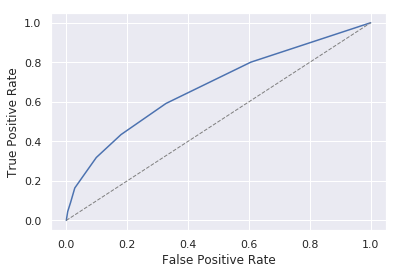

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Creating a function to predict flight delay

In [27]:
def predict_delay(departure_date_time, origin, destination):
    from datetime import datetime

    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [{'MONTH': month,
              'DAY': day,
              'DAY_OF_WEEK': day_of_week,
              'CRS_DEP_TIME': hour,
              'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
              'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
              'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
              'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
              'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
              'DEST_ATL': 1 if destination == 'ATL' else 0,
              'DEST_DTW': 1 if destination == 'DTW' else 0,
              'DEST_JFK': 1 if destination == 'JFK' else 0,
              'DEST_MSP': 1 if destination == 'MSP' else 0,
              'DEST_SEA': 1 if destination == 'SEA' else 0 }]

    return model.predict_proba(pd.DataFrame(input))[0][0]

Date input to the predict_delay function use the international date format dd/mm/year

# Testing the function

In [28]:
#Test 1 - JFK to ATL in Jan.
predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL')

#The result returned below is the probability that the flight will arrive on time

0.6

In [29]:
#Test 2 - JFK to ATL in Feb.
predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL')

#The result returned below is the probability that the flight will arrive on time

0.8

In [30]:
#Test 3 - ATL to SEA in Feb.
predict_delay('2/10/2018 10:00:00', 'ATL', 'SEA')

#The result returned below is the probability that the flight will arrive on time

1.0

# Testing the function over a range of days

(0.0, 1.0)

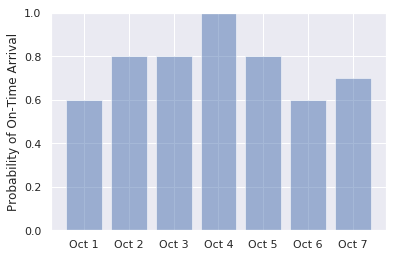

In [31]:
#Test 1 - JFK to ATL starting on Oct. 1 through Oct. 7 at 9:45pm
import numpy as np

labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('3/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('4/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('5/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('6/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('7/10/2018 21:45:00', 'JFK', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

(0.0, 1.0)

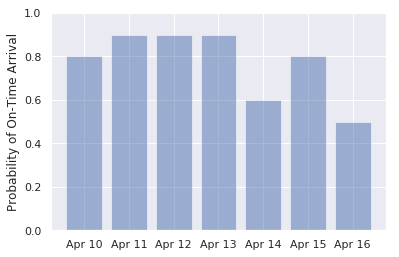

In [32]:
#Test 2 - JFK to MSP starting on Apr. 10 through Apr. 16 at 1:00pm
import numpy as np

labels = ('Apr 10', 'Apr 11', 'Apr 12', 'Apr 13', 'Apr 14', 'Apr 15', 'Apr 16')
values = (predict_delay('10/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('11/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('12/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('13/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('14/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('15/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('16/04/2018 13:00:00', 'JFK', 'MSP'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

On your own, write code to graph the probability that flights leaving SEA for ATL at 9:00 a.m., noon, 3:00 p.m., 6:00 p.m., and 9:00 p.m. on January 30 will arrive on time. Confirm that the output matches this:

(0.0, 1.0)

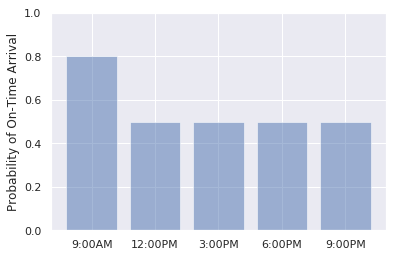

In [33]:
#Test 3 - SEA to ATL on Jan. 30 at 9:00am, 12:00pm, 3:00pm, 6:00pm, and 9:00pm
import numpy as np

labels = ('9:00AM', '12:00PM', '3:00PM', '6:00PM', '9:00PM')
values = (predict_delay('30/01/2018 09:00:00', 'SEA', 'ATL'),
          predict_delay('30/01/2018 12:00:00', 'SEA', 'ATL'),
          predict_delay('30/01/2018 15:00:00', 'SEA', 'ATL'),
          predict_delay('30/01/2018 18:00:00', 'SEA', 'ATL'),
          predict_delay('30/01/2018 21:00:00', 'SEA', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

In [34]:
#Test 4 - JFK to SEA on Feb. 2 at 3:20pm
predict_delay('02/02/2018 15:20:00', 'JFK', 'SEA')

#The result returned below is the probability that the flight will arrive on time

0.9